## Machine Learning: Data Modeling & Evaluation

In [1]:
import os
import time

from pyspark.sql import SparkSession
import pyspark 

from pyspark.sql.functions import lit
from pyspark.ml.feature import IndexToString
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit,CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml import Pipeline, PipelineModel

import math
import numpy as np
import pandas as pd


import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
spark = SparkSession \
    .builder \
    .appName("Book Recommender") \
    .config("spark.some.config.option", "some-value") \
    .config("spark.executor.memory","3g") \
    .config("spark.driver.maxResultSize", "1g") \
    .config("spark.executor.pyspark.memory","3g") \
    .getOrCreate()

sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Book Recommender>

### Loading Dataset

In [3]:
df = spark.read.csv(path = '../data/processed/explicit_ratings_books.csv', header = True,inferSchema = True)

In [4]:
df.printSchema()

root
 |-- userID: integer (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- author: string (nullable = true)
 |-- yearOfPublication: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- age: string (nullable = true)
 |-- country: string (nullable = true)



In [5]:
df.show(10,truncate=True)

+------+----------+------+--------------------+----------------+-----------------+--------------------+---+-------------+
|userID|      ISBN|rating|               title|          author|yearOfPublication|           publisher|age|      country|
+------+----------+------+--------------------+----------------+-----------------+--------------------+---+-------------+
|276726|0155061224|     5|    Rites of Passage|      Judith Rae|             2001|              Heinle| 34|          usa|
|276729|052165615X|     3|      Help!: Level 1|   Philip Prowse|             1999|Cambridge Univers...| 16|      croatia|
|276729|0521795028|     6|The Amsterdam Con...|     Sue Leather|             2001|Cambridge Univers...| 16|      croatia|
|276744|038550120X|     7|     A Painted House|    JOHN GRISHAM|             2001|           Doubleday| 34|          usa|
|276747|0060517794|     9|Little Altars Eve...|   Rebecca Wells|             2003|         HarperTorch| 25|          usa|
|276747|0671537458|     

In [6]:
df.count()

383842

In [7]:
df.describe()

DataFrame[summary: string, userID: string, ISBN: string, rating: string, title: string, author: string, yearOfPublication: string, publisher: string, age: string, country: string]

## Collaborative Filtering: Data Modeling using Alternating Least Square matrix (ALS)   

### Select required columns (UserID, ISBN, Ratings)

In [8]:
# selecting the columns to work with in the dataset, we do not need all columns for the prediction, only userID, ISBN & rating column 
data=df.select(df['userID'],df['ISBN'],df['rating'])
data.show()

+------+----------+------+
|userID|      ISBN|rating|
+------+----------+------+
|276726|0155061224|     5|
|276729|052165615X|     3|
|276729|0521795028|     6|
|276744|038550120X|     7|
|276747|0060517794|     9|
|276747|0671537458|     9|
|276747|0679776818|     8|
|276747|0943066433|     7|
|276747|1885408226|     7|
|276748|0747558167|     6|
|276751|3596218098|     8|
|276754|0684867621|     8|
|276755|0451166892|     5|
|276762|0380711524|     5|
|276762|3453092007|     8|
|276772|0553572369|     7|
|276772|3499230933|    10|
|276772|3596151465|    10|
|276774|3442136644|     9|
|276786|8437606322|     8|
+------+----------+------+
only showing top 20 rows



### Converting String Columns to index

ALS only accepts values in numeric form as parameters so before creating the ALS model we need to  to transform userID and ISBN columns into index form (unique ids).


In [9]:
# Converting String columns (userID & ISBN) to index
s_indexer = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in list(set(data.columns)-set(['rating'])) ]
pipeline = Pipeline(stages=s_indexer)
dftransform = pipeline.fit(data).transform(data)
dftransform.show()

+------+----------+------+------------+----------+
|userID|      ISBN|rating|userID_index|ISBN_index|
+------+----------+------+------------+----------+
|276726|0155061224|     5|     60067.0|   55543.0|
|276729|052165615X|     3|     23114.0|  134282.0|
|276729|0521795028|     6|     23114.0|   52232.0|
|276744|038550120X|     7|     61595.0|     218.0|
|276747|0060517794|     9|     11845.0|    1071.0|
|276747|0671537458|     9|     11845.0|    2642.0|
|276747|0679776818|     8|     11845.0|    1869.0|
|276747|0943066433|     7|     11845.0|  149514.0|
|276747|1885408226|     7|     11845.0|   72929.0|
|276748|0747558167|     6|     58244.0|   28184.0|
|276751|3596218098|     8|     60760.0|  134102.0|
|276754|0684867621|     8|     35835.0|     373.0|
|276755|0451166892|     5|     63300.0|     197.0|
|276762|0380711524|     5|     27654.0|    2670.0|
|276762|3453092007|     8|     27654.0|   22005.0|
|276772|0553572369|     7|     20024.0|    7200.0|
|276772|3499230933|    10|     

**NOTE:** Since the dataset is pretty huge, limited it to work with only 50000 records for now, because more than that is too much of a bottleneck for my laptop and required so much processing power and I could not run/accomplish much.

In [10]:
# limiting it to work with only 50000 records
dftransform = dftransform.limit(50000)
dftransform.show()

+------+----------+------+------------+----------+
|userID|      ISBN|rating|userID_index|ISBN_index|
+------+----------+------+------------+----------+
|276726|0155061224|     5|     60067.0|   55543.0|
|276729|052165615X|     3|     23114.0|  134282.0|
|276729|0521795028|     6|     23114.0|   52232.0|
|276744|038550120X|     7|     61595.0|     218.0|
|276747|0060517794|     9|     11845.0|    1071.0|
|276747|0671537458|     9|     11845.0|    2642.0|
|276747|0679776818|     8|     11845.0|    1869.0|
|276747|0943066433|     7|     11845.0|  149514.0|
|276747|1885408226|     7|     11845.0|   72929.0|
|276748|0747558167|     6|     58244.0|   28184.0|
|276751|3596218098|     8|     60760.0|  134102.0|
|276754|0684867621|     8|     35835.0|     373.0|
|276755|0451166892|     5|     63300.0|     197.0|
|276762|0380711524|     5|     27654.0|    2670.0|
|276762|3453092007|     8|     27654.0|   22005.0|
|276772|0553572369|     7|     20024.0|    7200.0|
|276772|3499230933|    10|     

### Splitting into Train and Test data


In order to train, we are going to split the data into 80% training set and 20% testing set.

In [11]:
# splitting dataset into train and test
print ("\n* Spliting training and testing datasets")
(train,test)=dftransform.randomSplit([0.8, 0.2],seed = 1 )
print("  Train dataset:", train.count(), "rows")
print("  Test dataset: ", test.count(), "rows")


* Spliting training and testing datasets
  Train dataset: 40006 rows
  Test dataset:  9994 rows


### ALS modeling and fitting data

 Will be making use of Alternating least square matrix factorization method,which is a collaborative filtering algorithm. 

In [12]:
# Build the recommendation model by using ALS on the training data
# Note: setting cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als=ALS(maxIter=22,regParam=0.7,rank=12,userCol="userID_index",itemCol="ISBN_index",ratingCol="rating",coldStartStrategy="drop",nonnegative=True)
model=als.fit(train)

### Predictions and Model Evaluation (RMSE )

In [13]:
# function to calculate RMSE/MSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
def RMSE(predictions):
    return evaluator.evaluate(predictions)

In [14]:
# Evaluating the model by computing the RMSE on the test data
predictions=model.transform(test)
print('RMSE = ' + str(RMSE(predictions)))
print("Predictions:")
predictions.show()

RMSE = 2.623985726417399
Predictions:
+------+----------+------+------------+----------+----------+
|userID|      ISBN|rating|userID_index|ISBN_index|prediction|
+------+----------+------+------------+----------+----------+
|  7915|0609804138|     3|      1144.0|     148.0| 7.1597757|
|  5737|0609804138|     9|     16014.0|     148.0|  5.397538|
| 25844|0609804138|     9|     17800.0|     148.0|  7.094673|
|  4225|0451202341|     6|     14840.0|     496.0| 5.5235248|
|   486|0451202341|     8|     16433.0|     496.0| 6.1267595|
|  7253|067101420X|     8|     19889.0|     833.0| 3.3797696|
| 25981|067101420X|     5|        46.0|     833.0| 3.3571694|
| 11676|067101420X|     4|         0.0|     833.0| 3.8147435|
| 27647|0140276904|     5|       593.0|    1580.0| 6.4095345|
| 16504|0140276904|     5|      3207.0|    1580.0|  6.465555|
| 22365|0425097722|     9|      2726.0|    1959.0|   7.21601|
| 20201|0812551478|    10|       894.0|    2122.0|  5.795143|
| 28451|0515119202|     6|      

### Recommendations

In [15]:
print("Top 10 book recommendations for each user :")
user_recs=model.recommendForAllUsers(10).show(10)

Top 10 book recommendations for each user :
+------------+--------------------+
|userID_index|     recommendations|
+------------+--------------------+
|        7340|[[92616, 9.222811...|
|       21220|[[92616, 11.20486...|
|       54190|[[109600, 7.79588...|
|       56110|[[147463, 6.25453...|
|       56640|[[108426, 9.65228...|
|       11141|[[6644, 7.652112]...|
|       23271|[[24002, 7.313163...|
|       57201|[[5586, 9.949873]...|
|       10362|[[24002, 9.760585...|
|       67492|[[48770, 8.670118...|
+------------+--------------------+
only showing top 10 rows



In [16]:
print("Top 10 user recommendations for each Book :")
book_recs=model.recommendForAllItems(10).show(10)

Top 10 user recommendations for each Book :
+----------+--------------------+
|ISBN_index|     recommendations|
+----------+--------------------+
|       148|[[26093, 10.47134...|
|       463|[[22278, 8.438749...|
|       471|[[22278, 9.702738...|
|       496|[[45913, 9.177088...|
|       833|[[22278, 6.221591...|
|      1088|[[46035, 7.733388...|
|      1238|[[22278, 11.40866...|
|      1342|[[22278, 6.279748...|
|      1580|[[26093, 9.067789...|
|      1591|[[22278, 11.33785...|
+----------+--------------------+
only showing top 10 rows



### Testing Book Recommendations Model

In [17]:
# The following function is to test predictions for selected user
def recommendBooks(model, user, num_rec):
    print("Results of distinct books from the selected user :")
    # Here we create a dataset with distinct books as one column and the userID 
    items_user = train.select("ISBN_index").distinct().withColumn("userID_index", lit(user))
    items_user.show(n=5)

    # filter out Books that the user has already rated 
    booksrated = train.filter(train.userID_index == user).select("ISBN_index", "userID_index")

    # application of the trained book als recommender system
    predictions = model.transform(items_user.subtract(booksrated)).dropna().orderBy("prediction", ascending=False).limit(num_rec).select("ISBN_index", "prediction")

    # convert index back to original ISBN
    print("Predicted Recommended Books for the user with the Original ISBN :")
    converter = IndexToString(inputCol="ISBN_index", outputCol="original_ISBN")
    converted = converter.transform(predictions)
    converted.show()

In [18]:
#  random picked user from dataset of userID_index:3207 and display 10 book recommendations for the user
recommendBooks(model,3207,10)

Results of distinct books from the selected user :
+----------+------------+
|ISBN_index|userID_index|
+----------+------------+
|    5547.0|        3207|
|  102800.0|        3207|
|   98687.0|        3207|
|   94472.0|        3207|
|   96814.0|        3207|
+----------+------------+
only showing top 5 rows

Predicted Recommended Books for the user with the Original ISBN :
+----------+----------+-------------+
|ISBN_index|prediction|original_ISBN|
+----------+----------+-------------+
|   24002.0|  10.40366|   0670829390|
|   41441.0|  9.947877|   0783547528|
|   46846.0|  9.947877|   0743526279|
|  136945.0|  9.947877|   0671432672|
|  121820.0|  9.947877|   0895860775|
|   63469.0|  9.947877|   0793820103|
|   44687.0|  9.947877|   042509345X|
|   14704.0|  9.947877|   0671827847|
|    7072.0|  9.947877|   0843950463|
|  141471.0|  9.947877|   0843122749|
+----------+----------+-------------+



### Prediction Visualization

Plot to compare the true and predicted ratings.

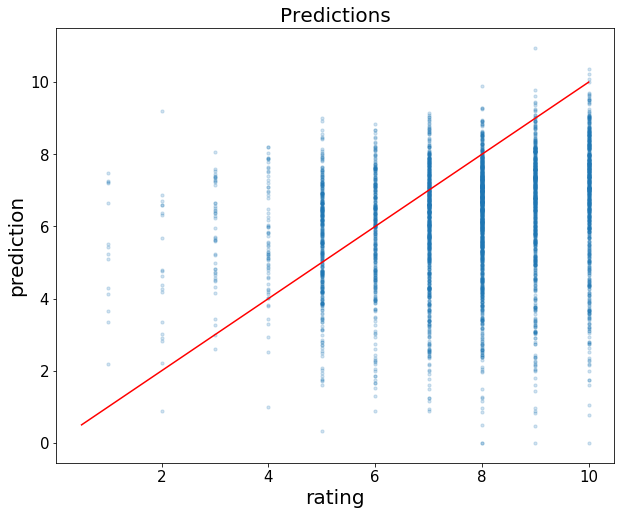

In [19]:
# plot predictions

df = predictions.toPandas()
x = np.arange(0.5, 10.1, 0.5) 
fig = plt.figure(figsize=(10,8))
plt.tick_params(labelsize=15)
plt.scatter(df.rating, df.prediction, s = 10, alpha = 0.2)
plt.plot(x, x, c = 'r')
plt.xlabel('rating', fontsize=20)
plt.ylabel('prediction', fontsize=20)
plt.title('Predictions', fontsize=20)
plt.show()

We can see from the plot, the predictions from the model were fairly not bad.

## Conclusions and Future Steps


In this project we were able to build a book recommender that could predict books for users. We have also used the ALS colaborative filtering method and have seen, the model works fairly okay, but not as good as I expected it according to the RMSE, probably also due to the fact that we didnt use the complete large dataset, which would have given better results. We have made use of only 3 columns in the dataset, namely  "user ID", "ISBN", and "rating". We also discovered that the matrix factorization way can help solve the popular bias and user/item cold-start problems in collaborative filtering.

A limit is that we could not use all the data as I wanted, but had to take a portion of it for training because of limitations with computing power.

In future, to do more anaylsis with the dataset and work with more variables (columns) such as country etc and use other machine learning algorithms for training such as SVM etc to build better model or compare against.

Also use this model and develop a userfriendly frontend application to recommend books to new and old users. 